In [2]:
import pandas as pd 
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import lazypredict
import xgboost as xgb

from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score

from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [3]:
def make_submission(preds: np.array):
    assert len(preds) == 5000
    
    # Read labels
    with open('test_labels_sorted.npy', 'rb') as f:
        test_labels = np.load(f)
    len(test_labels)
    
    # Create DataFrame structure for submissions
    submission = pd.DataFrame(columns=['id', 'class'])
    for label, pred in zip(test_labels, preds):
        submission = submission.append({'id': label, 'class': pred}, ignore_index=True)
    return submission

In [4]:
def plot_confusion_matrix(y_val_from_train: np.array, y_pred_from_train: np.array):
    """Plot confusion matrix given predictions and truth values"""
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_val_from_train, y_pred_from_train))
    cmp.plot(ax=ax)
    plt.show()

# For total of 43 features

## Load X_train, y_train, X_test

In [5]:
# Load X_train
with open('X_train_43.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 43)


array([[-8.81665000e-01,  1.04447100e+00,  1.59010940e-01, ...,
         1.29894686e+00,  9.86426663e-02,  1.29471645e+01],
       [-1.10552300e+00,  1.12647200e+00,  1.74547752e-01, ...,
         1.29363158e+00,  1.42413478e-01,  1.38184886e+01],
       [-2.64679000e+00,  3.47160000e-02, -1.61696002e+00, ...,
         2.62288645e+00,  1.06095621e-01,  1.33114980e+01],
       ...,
       [-1.56939900e+00,  8.21211000e-01, -4.06112460e-01, ...,
         2.09723416e+00,  1.60231251e-01,  1.38336216e+01],
       [-1.09474900e+00,  1.15340700e+00,  8.15228667e-03, ...,
         1.54660804e+00,  1.99383090e-01,  1.39800549e+01],
       [-1.13664700e+00,  8.64905000e-01, -5.17633651e-01, ...,
         2.32898748e+00,  8.26406975e-02,  1.37358806e+01]])

In [6]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [7]:
# Load X_train
with open('X_test_43.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 43)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         1.93942445e+00,  2.14040399e-01,  1.37640621e+01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         1.96847954e+00,  1.19986868e-01,  1.29569175e+01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         2.73514368e+00,  1.54109933e-01,  1.39464683e+01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         1.54247731e+00,  8.17718765e-02,  1.29786762e+01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         2.68148493e+00,  9.04578235e-02,  1.42111488e+01],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         2.40775477e+00,  1.33443744e-01,  1.25388069e+01]])

In [8]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

# Let's try an Ensemble Stacking Classifier

In [33]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)

etc_clf = ExtraTreesClassifier(random_state=42, n_jobs=-1, warm_start=True, max_depth=30, min_samples_split=2, \
                               min_samples_leaf=1, n_estimators=2000)

gb_clf = GradientBoostingClassifier(learning_rate=0.2, max_depth=8, max_features='sqrt', min_samples_leaf=0.1, \
                           min_samples_split=0.17272727272727273, subsample=0.85, n_estimators=2000)


lgb_clf = lgb.LGBMClassifier(boosting_type='dart', objective='multiclass', n_jobs=-1, colsample_bytree=0.696, learning_rate=0.07, \
                              max_bin=400, max_depth=13, num_leaves=50, reg_alpha=0.3, reg_lambda=0, subsample=0.7, n_estimators=2000)

cbc_clf = CatBoostClassifier()

estimators = [("etc", etc_clf), ("gb", gb_clf), ("lgb", lgb_clf), ("cbc", cbc_clf)]
ensemble_estimators = StackingClassifier(estimators, final_estimator=LogisticRegression())

In [34]:
%%time
ensemble_estimators.fit(X_train_from_train, y_train_from_train)

Learning rate set to 0.087779
0:	learn: 2.4467519	total: 80.8ms	remaining: 1m 20s
1:	learn: 2.1081084	total: 170ms	remaining: 1m 24s
2:	learn: 1.8713691	total: 247ms	remaining: 1m 22s
3:	learn: 1.7011950	total: 322ms	remaining: 1m 20s
4:	learn: 1.5577393	total: 405ms	remaining: 1m 20s
5:	learn: 1.4505038	total: 482ms	remaining: 1m 19s
6:	learn: 1.3606543	total: 561ms	remaining: 1m 19s
7:	learn: 1.2756043	total: 647ms	remaining: 1m 20s
8:	learn: 1.1978196	total: 731ms	remaining: 1m 20s
9:	learn: 1.1204879	total: 812ms	remaining: 1m 20s
10:	learn: 1.0591682	total: 894ms	remaining: 1m 20s
11:	learn: 1.0061393	total: 971ms	remaining: 1m 19s
12:	learn: 0.9576520	total: 1.05s	remaining: 1m 19s
13:	learn: 0.9104426	total: 1.12s	remaining: 1m 19s
14:	learn: 0.8680080	total: 1.2s	remaining: 1m 18s
15:	learn: 0.8312679	total: 1.28s	remaining: 1m 18s
16:	learn: 0.7977000	total: 1.35s	remaining: 1m 18s
17:	learn: 0.7659752	total: 1.42s	remaining: 1m 17s
18:	learn: 0.7379245	total: 1.5s	remaining: 

StackingClassifier(estimators=[('etc',
                                ExtraTreesClassifier(max_depth=30,
                                                     n_estimators=2000,
                                                     n_jobs=-1, random_state=42,
                                                     warm_start=True)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=8,
                                                           max_features='sqrt',
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.17272727272727273,
                                                           n_estimators=2000,
                                                           subsample=0.85)),
                               ('lgb',
                            

In [35]:
# Validation predict
y_pred_from_train = ensemble_estimators.predict(X_val_from_train)

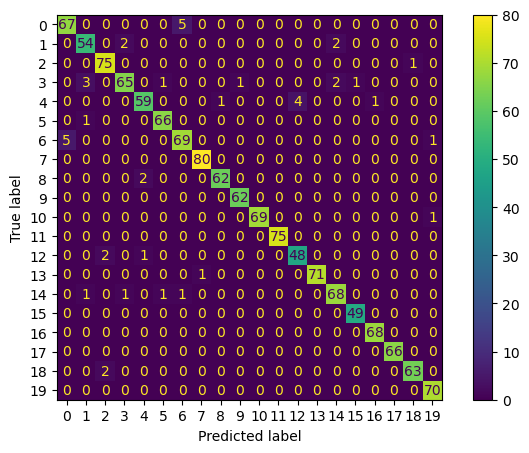

In [36]:
# Plot Confusion Matrix
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [38]:
# Accuracy Score
accuracy_score(y_val_from_train, y_pred_from_train) # 96.674% currently

0.9674074074074074

### Train on the whole data

In [39]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)

etc_clf = ExtraTreesClassifier(random_state=42, n_jobs=-1, warm_start=True, max_depth=30, min_samples_split=2, \
                               min_samples_leaf=1, n_estimators=2000)

gb_clf = GradientBoostingClassifier(learning_rate=0.2, max_depth=8, max_features='sqrt', min_samples_leaf=0.1, \
                           min_samples_split=0.17272727272727273, subsample=0.85, n_estimators=2000)


lgb_clf = lgb.LGBMClassifier(boosting_type='dart', objective='multiclass', n_jobs=-1, colsample_bytree=0.696, learning_rate=0.07, \
                              max_bin=400, max_depth=13, num_leaves=50, reg_alpha=0.3, reg_lambda=0, subsample=0.7, n_estimators=2000)

cbc_clf = CatBoostClassifier()

estimators = [("etc", etc_clf), ("gb", gb_clf), ("lgb", lgb_clf), ("cbc", cbc_clf)]
ensemble_estimators = StackingClassifier(estimators, final_estimator=LogisticRegression())

In [40]:
%%time
ensemble_estimators.fit(X_train, y_train)

Learning rate set to 0.088509
0:	learn: 2.4416567	total: 85ms	remaining: 1m 24s
1:	learn: 2.0881549	total: 166ms	remaining: 1m 23s
2:	learn: 1.8624706	total: 249ms	remaining: 1m 22s
3:	learn: 1.6910979	total: 332ms	remaining: 1m 22s
4:	learn: 1.5558310	total: 425ms	remaining: 1m 24s
5:	learn: 1.4432283	total: 520ms	remaining: 1m 26s
6:	learn: 1.3418523	total: 610ms	remaining: 1m 26s
7:	learn: 1.2565671	total: 701ms	remaining: 1m 26s
8:	learn: 1.1760909	total: 785ms	remaining: 1m 26s
9:	learn: 1.1109727	total: 869ms	remaining: 1m 25s
10:	learn: 1.0498171	total: 952ms	remaining: 1m 25s
11:	learn: 0.9939619	total: 1.04s	remaining: 1m 25s
12:	learn: 0.9457191	total: 1.12s	remaining: 1m 24s
13:	learn: 0.9056499	total: 1.2s	remaining: 1m 24s
14:	learn: 0.8651577	total: 1.29s	remaining: 1m 24s
15:	learn: 0.8288207	total: 1.39s	remaining: 1m 25s
16:	learn: 0.7946834	total: 1.47s	remaining: 1m 25s
17:	learn: 0.7612435	total: 1.56s	remaining: 1m 24s
18:	learn: 0.7297970	total: 1.64s	remaining: 1

StackingClassifier(estimators=[('etc',
                                ExtraTreesClassifier(max_depth=30,
                                                     n_estimators=2000,
                                                     n_jobs=-1, random_state=42,
                                                     warm_start=True)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=8,
                                                           max_features='sqrt',
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.17272727272727273,
                                                           n_estimators=2000,
                                                           subsample=0.85)),
                               ('lgb',
                            

### Evaluate models

In [44]:
%%time
results_list = []
estimator_list = []
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=69)

for estimator_name, clf in estimators:
    results = cross_val_score(clf, X_train_from_train, y_train_from_train, scoring='accuracy', cv=cv, n_jobs=-1)
    estimator_list.append(estimator_name)
    results_list.append(results)
    
    print('>%s %.3f (%.3f)' % (estimator_name, np.mean(results), np.std(results)))
#     print(f"Estimator {estimator} has mean ({mean(results)}) and standard dev ({std(results)})")

>etc 0.952 (0.003)
>gb 0.957 (0.004)
>lgb 0.953 (0.005)
>cbc 0.954 (0.004)
Wall time: 24min 50s


Evaluation for 6 models, 43f:
```
>svc 0.947 (0.007)
>etc 0.954 (0.007)
>gb 0.961 (0.007)
>lgb 0.959 (0.008)
>lr 0.941 (0.008)
>xgb nan (nan)
>cbc 0.961 (0.007)
```

### Generate submission for ensemble

In [41]:
preds = ensemble_estimators.predict(X_test)
preds

array([3, 4, 5, ..., 4, 5, 1], dtype=int64)

In [42]:
sub = make_submission(preds)
sub

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,13
...,...,...
4995,23986,9
4996,23991,12
4997,23992,4
4998,23998,5


In [43]:
sub.to_csv('submission_ensemble_baseline_64f_4_models.csv', index=False)

# Let's try for 24 features per axis

## Load X_train, y_train, X_test

In [39]:
# Load X_train
with open('X_train_24.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 24)


array([[-0.881665  ,  1.044471  ,  0.15901094, ...,  0.14329861,
         0.29854766,  1.72087463],
       [-1.105523  ,  1.126472  ,  0.17454775, ...,  0.18043879,
        -0.20785722, -0.07204283],
       [-2.64679   ,  0.034716  , -1.61696002, ...,  0.09802465,
         1.79855361,  6.20649724],
       ...,
       [-1.569399  ,  0.821211  , -0.40611246, ...,  0.17958009,
         0.16936675,  0.38527156],
       [-1.094749  ,  1.153407  ,  0.00815229, ...,  0.59477687,
         0.09159904,  0.32757404],
       [-1.136647  ,  0.864905  , -0.51763365, ...,  0.1212113 ,
        -0.98257849, -0.01119592]])

In [40]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [41]:
# Load X_train
with open('X_test_24.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 24)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         6.41653222e-01, -2.70378930e-01, -6.56709631e-01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         1.26971131e-01, -1.12422501e-01, -3.54827836e-01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         9.30784537e-02,  2.81907035e-01,  6.14209125e-01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         2.57441289e-01,  3.60590805e-01, -7.93530596e-01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         1.49931026e-01,  1.18705530e-02, -1.01464047e+00],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         2.83123897e-01, -4.80041145e-01,  5.33925135e+00]])

In [42]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

In [43]:
print(X_train_from_train.shape)

(7650, 24)


# Let's try for 64f 

In [2]:
# Load X_train
with open('X_train_64.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 64)


array([[-8.81665000e-01,  1.04447100e+00,  1.59010940e-01, ...,
         7.64136797e-02,  2.23461397e-02,  1.29471645e+01],
       [-1.10552300e+00,  1.12647200e+00,  1.74547752e-01, ...,
         1.13979068e-01,  2.85805084e-02,  1.38184886e+01],
       [-2.64679000e+00,  3.47160000e-02, -1.61696002e+00, ...,
         7.77954261e-02,  3.10021816e-02,  1.33114980e+01],
       ...,
       [-1.56939900e+00,  8.21211000e-01, -4.06112460e-01, ...,
         1.29546035e-01,  3.10393141e-02,  1.38336216e+01],
       [-1.09474900e+00,  1.15340700e+00,  8.15228667e-03, ...,
         1.52495097e-01,  4.72684630e-02,  1.39800549e+01],
       [-1.13664700e+00,  8.64905000e-01, -5.17633651e-01, ...,
         5.24448737e-02,  3.02990790e-02,  1.37358806e+01]])

In [3]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [4]:
# Load X_train
with open('X_test_64.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 64)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         1.69465441e-01,  4.55106589e-02,  1.37640621e+01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         9.01118934e-02,  3.03245873e-02,  1.29569175e+01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         1.27677673e-01,  2.67303936e-02,  1.39464683e+01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         5.26696304e-02,  2.91492287e-02,  1.29786762e+01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         7.00060125e-02,  2.16020454e-02,  1.42111488e+01],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         1.12113293e-01,  2.19392284e-02,  1.25388069e+01]])

In [5]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# Then just re-run the code above for training

## Perform hyperparam tuning with Optuna for LGBM -> Move into NB10 after it's done

In [1]:
import pandas as pd 
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import lazypredict
import xgboost as xgb

from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score

import optuna
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [12]:
def get_objective(X_train, y_train, X_valid, y_valid):
    def objective(trial):
        hyperparams = {
            "min_child_samples": trial.suggest_int("min_child_samples", 3, 20),
            "num_iterations": trial.suggest_int("num_iterations", 100, 2000),
            "num_leaves": trial.suggest_int("num_leaves", 20, 100),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 100),
            "max_bin": trial.suggest_int("max_bin", 20, 200),
            "max_depth": trial.suggest_int("max_depth", -1, 100),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, step=0.01),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 0.03)
        }
        model = lgb.LGBMClassifier(objective='multiclass', num_class=20, n_jobs=-1, seed=42, boosting='dart', **hyperparams)
        model.fit(X_train, y_train)
        y_pred_from_train = model.predict(X_valid)
        score = accuracy_score(y_valid, y_pred_from_train)
        
        return score
    return objective

In [13]:
objective = get_objective(X_train_from_train, y_train_from_train, X_val_from_train, y_val_from_train)
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=500, show_progress_bar=True)
best_params = study.best_params if study.trials else {}

  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Cur

In [14]:
best_params

{'min_child_samples': 12,
 'num_iterations': 1936,
 'num_leaves': 66,
 'min_data_in_leaf': 50,
 'max_bin': 20,
 'max_depth': 17,
 'learning_rate': 0.24,
 'reg_alpha': 0.0004127769671094072}

## Perform Hyperparam tuning for GradientBoostingClassifier using BayesSearchCV

In [23]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8, 13, 15, 17, 19, 23],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
}

In [24]:
cv = RepeatedStratifiedKFold(n_splits=3, random_state=1)
gb = GradientBoostingClassifier()
bs = BayesSearchCV(gb, param_grid, verbose=1, cv=cv, n_jobs=-1)

In [25]:
%%time
bs.fit(X_train_from_train, y_train_from_train)

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for eac

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=1),
              estimator=GradientBoostingClassifier(), n_jobs=-1,
              search_spaces={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1,
                                               0.15, 0.2],
                             'max_depth': [3, 5, 8, 13, 15, 17, 19, 23],
                             'min_samples_leaf': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
                             'min_samples_split': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
                             'subsample': [0.5, 0.618, 0.8, 0.85, 0.9, 0.95,
                                           1.0]},
              verbose=1)

In [26]:
# Print the best parameters found
print(bs.best_params_)
print(bs.best_score_)
print(bs.best_estimator_)

OrderedDict([('learning_rate', 0.2), ('max_depth', 5), ('min_samples_leaf', 0.1), ('min_samples_split', 0.13636363636363638), ('subsample', 1.0)])
0.9476601307189544
GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=0.1,
                           min_samples_split=0.13636363636363638)
